In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import math
import zipfile
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# extract data
path_to_zip_file = 'birds.zip'
directory_to_extract_to = 'birds'

if not os.path.exists(directory_to_extract_to):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [3]:
# get labels
TRAIN_PATH = os.path.join('birds', 'train')
VAL_PATH = os.path.join('birds', 'valid')
TEST_PATH = os.path.join('birds', 'test')

labels = {}

for i, label in enumerate(os.listdir(TRAIN_PATH)):
    labels[label] = i
    
# onehot_labels = F.one_hot(torch.arange(0, len(labels.keys())))
# for i, label in enumerate(labels):
#     labels[label] = onehot_labels[i]

In [4]:
labels

{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'AFRICAN PYGMY GOOSE': 8,
 'ALBATROSS': 9,
 'ALBERTS TOWHEE': 10,
 'ALEXANDRINE PARAKEET': 11,
 'ALPINE CHOUGH': 12,
 'ALTAMIRA YELLOWTHROAT': 13,
 'AMERICAN AVOCET': 14,
 'AMERICAN BITTERN': 15,
 'AMERICAN COOT': 16,
 'AMERICAN FLAMINGO': 17,
 'AMERICAN GOLDFINCH': 18,
 'AMERICAN KESTREL': 19}

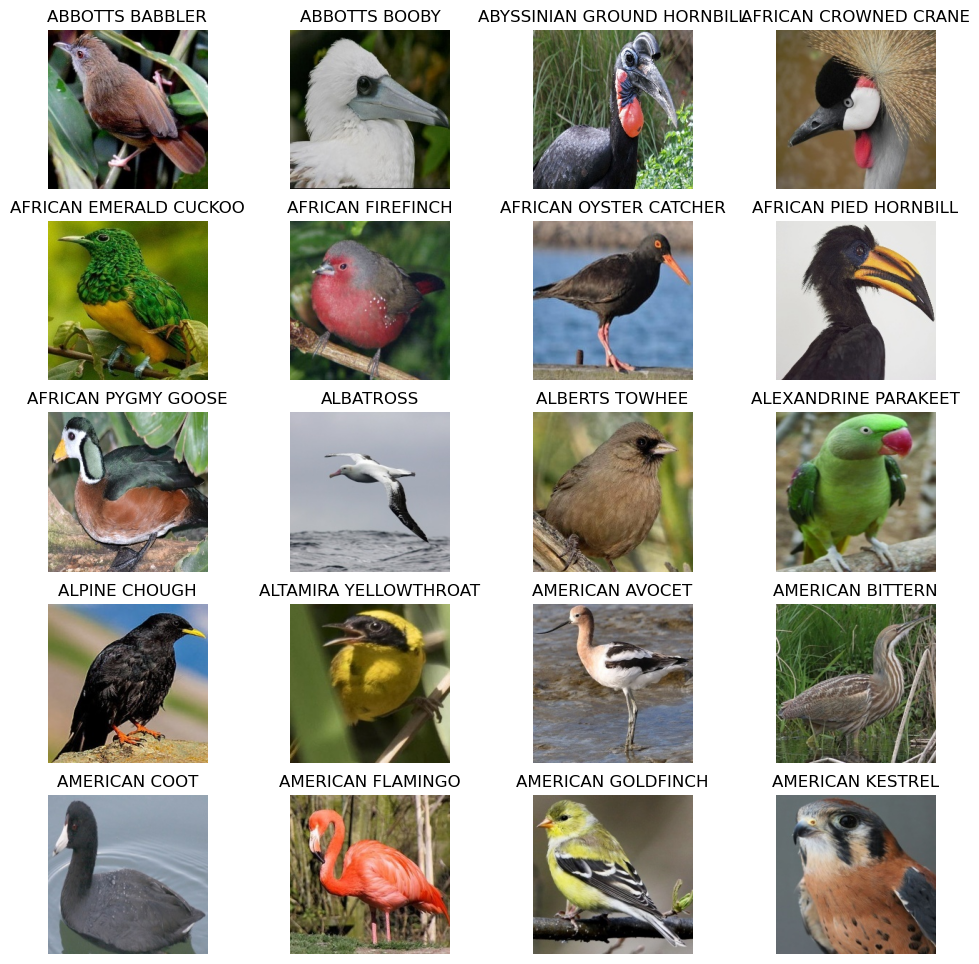

In [5]:
# display sample images
sample_img_list = []
for i, label in enumerate(os.listdir(TEST_PATH)):
    path = os.path.join(TEST_PATH, label, '1.jpg')
    sample_img_list.append(torchvision.io.read_image(path)
                           .permute(1, 2, 0).numpy())
    
nrows = 5
ncols = math.ceil(len(sample_img_list) / nrows)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(12,12))
axes = axes.flatten()
for i, label in enumerate(os.listdir(TEST_PATH)):
    axes[i].imshow(sample_img_list[i])
    axes[i].set_axis_off()
    axes[i].set_title(label)
plt.show()

In [6]:
batch_size = 64 # if you encounter cannot training issue, reduce the size to 32 or smaller

In [7]:
# get dataset
def get_data_tensor(PATH):
    label_list = []
    img_list = []
    for label in os.listdir(PATH):
        for img_name in os.listdir(os.path.join(PATH, label)):
            path = os.path.join(PATH, label, img_name)
            img_list.append(torchvision.io.read_image(path)
                            .unsqueeze(dim=0))
            label_list.append(torch.tensor(labels[label])
                              .unsqueeze(dim=0))
    return torch.cat(img_list) / 255., torch.cat(label_list)

train_imgs, train_labels = get_data_tensor(TRAIN_PATH)
valid_imgs, valid_labels = get_data_tensor(VAL_PATH)
test_imgs, test_labels = get_data_tensor(TEST_PATH)

class CustomImageDataset(Dataset):
    def __init__(self, img_tensor, label_tensor,
                 transform=None, target_transform=None):
        self.img_tensor = img_tensor
        self.label_tensor = label_tensor
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.label_tensor.shape[0]

    def __getitem__(self, idx):
        image = self.img_tensor[idx]
        label = self.label_tensor[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
train_dataset = CustomImageDataset(train_imgs, train_labels)
valid_dataset = CustomImageDataset(valid_imgs, valid_labels)
test_dataset = CustomImageDataset(test_imgs, test_labels)

# get dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size, shuffle=True)

In [8]:
# image size
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [9]:
# a general conv block that conv2d with batch normalization and relu activation
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_chanels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_chanels, **kwargs)
        self.bn = nn.BatchNorm2d(out_chanels)
        
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

# a vanilla Inception Res Block, concat input layer with multiple small layers
class Inception_Res_Block(nn.Module):
    def __init__(
        self, 
        in_channels, 
        out_1x1,
        red_3x3,
        out_3x3,
        red_5x5,
        out_5x5,
        out_pool,
    ):
        super(Inception_Res_Block, self).__init__()
        self.shortcut = nn.Sequential(
            ConvBlock(in_channels, out_1x1+out_3x3+out_5x5+out_pool, kernel_size=1)
        )
        self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, red_3x3, kernel_size=1, padding=0),
            ConvBlock(red_3x3, out_3x3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, red_5x5, kernel_size=1),
            ConvBlock(red_5x5, out_5x5, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            ConvBlock(in_channels, out_pool, kernel_size=1),
        )
        self.bn = nn.BatchNorm2d(out_1x1+out_3x3+out_5x5+out_pool)
    
    def forward(self, x):
        shortcut = self.shortcut(x)
        branches = (self.branch1, self.branch2, self.branch3, self.branch4)
        return F.relu(self.bn(torch.cat([branch(x) for branch in branches], 1) + shortcut))
    
class Inception_ResNet(nn.Module):
    def __init__(self, num_classes=1, in_channels=1):
        super(Inception_ResNet, self).__init__()
        self.conv1 = ConvBlock(in_channels, 32, kernel_size=7, stride=1, padding=1)
        self.conv2 = ConvBlock(32, 64, kernel_size=3, stride=1, padding=1)
        self.inception_a1 = Inception_Res_Block(64, 64, 64, 96, 64, 32, 32)
        self.inception_a2 = Inception_Res_Block(224, 64, 64, 96, 64, 32, 32)
        self.inception_b1 = Inception_Res_Block(224, 96, 96, 128, 96, 64, 64)
        self.inception_b2 = Inception_Res_Block(352, 96, 96, 128, 96, 64, 64)
        self.inception_c1 = Inception_Res_Block(352, 128, 128, 192, 128, 96, 96)
        self.inception_c2 = Inception_Res_Block(512, 128, 128, 192, 128, 96, 96)
        self.inception_d1 = Inception_Res_Block(512, 192, 192, 256, 192, 128, 128)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=3)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(704, num_classes)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.inception_a1(x)
        x = self.inception_a2(x)
        x = self.maxpool(x)
        x = self.inception_b1(x)
        x = self.inception_b2(x)
        x = self.maxpool(x)
        x = self.inception_c1(x) 
        x = self.inception_c2(x)
        x = self.maxpool(x)
        x = self.inception_d1(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
class CNN_conv8_Net(nn.Module):
    def __init__(self, num_classes=1, in_channels=1):
        super(CNN_conv8_Net, self).__init__()
        self.conv1 = ConvBlock(in_channels, 32, kernel_size=7, stride=3, padding=1)
        self.conv2 = ConvBlock(32, 64, kernel_size=5, stride=2, padding=1)
        self.conv3 = ConvBlock(64, 128, kernel_size=5, stride=1, padding=1)
        self.conv4 = ConvBlock(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = ConvBlock(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = ConvBlock(256, 512, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=3)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
class CNN_conv4_Net(nn.Module):
    def __init__(self, num_classes=1, in_channels=1):
        super(CNN_conv4_Net, self).__init__()
        self.conv1 = ConvBlock(in_channels, 32, kernel_size=7, stride=3, padding=1)
        self.conv2 = ConvBlock(32, 64, kernel_size=5, stride=2, padding=1)
        self.conv3 = ConvBlock(64, 128, kernel_size=5, stride=2, padding=1)
        self.conv4 = ConvBlock(128, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=3)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(256, num_classes)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [10]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float) 
            y = y.to(device=device, dtype=torch.int)
            scores = model(x)
            preds = torch.argmax(scores, dim=1)
            num_correct += (preds.to('cpu') == y.to('cpu')).sum()
            num_samples += preds.size(0)         
        acc = float(num_correct) / num_samples

    return acc

In [11]:
def train(train_dataloader, valid_dataloader, model, 
          criterion, optimizer, epochs=5, 
          save_best=False, best_strategy='loss'):
    training_losses = []
    validation_accs = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        training_loss = -1
        for i, data in enumerate(train_dataloader):
            model.train()             
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()        
            # forward + backward + optimize
            outputs = model(inputs)
            training_loss = criterion(outputs, labels)
            training_loss.backward()
            optimizer.step()
        # record
        validation_acc = check_accuracy(valid_dataloader, model)     
        training_losses.append(training_loss.item())
        validation_accs.append(validation_acc)
        # print record
        print(f'epoch: {epoch} \t training loss: {training_losses[epoch]:.3f}'
              f'\t test accuracy: {100*validation_accs[epoch]:.2f}%')
        
        best_weight = None
        # save the best model with lowest loss or best validation accuracy
        if save_best == True and best_strategy=='loss' and \
            (training_losses == [] or training_loss < min(training_losses)):
            best_weight = model.state_dict()
        elif save_best == True and best_strategy=='acc' and \
            (training_losses == [] or validation_acc > max(validation_accs)):
            best_weight = model.state_dict()
    
    if best_weight == None:
        best_weight = model.state_dict()
    
    print('Finished Training')    
    return training_losses, validation_accs, best_weight

In [12]:
def get_confusion_matrix(loader, model):
    y_true = []
    y_pred = []
    model.eval()  
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float) 
            y = y.to(device=device, dtype=torch.int)
            scores = model(x)
            preds = torch.argmax(scores, dim=1)
            y_true += y.tolist()
            y_pred += preds.tolist()
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [13]:
# plot the training loss and validation accuracy of model
def training_history_plot(training_losses, validation_accs, epochs):
    fig, ax = plt.subplots(1,2,figsize = (16,4))
    epochs_enum = range(epochs)
    ax[0].plot(range(epochs), training_losses,color='#EFAEA4', label='Training Loss')
    ax[1].plot(range(epochs), validation_accs,color='#B2D7D0', label='Validation Accuracy')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs');
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Accuracy');
    fig.suptitle('Training History', fontsize = 18)
    plt.show()

In [14]:
def train_save_model(model_name, train_dataloader, valid_dataloader, 
                     save_best=False, best_strategy='loss',                     
                     epochs=50, lr=0.001, betas=(0.9, 0.999), weight_decay=0):
    # available model
    if model_name == 'efficientnet':
        model = model = torchvision.models.efficientnet_v2_s().to(device)
    elif model_name == 'resnet18':
        model = torchvision.models.resnet18().to(device)
    elif model_name == 'inception_res':
        model = Inception_ResNet(num_classes=20, in_channels=3).to(device)
    elif model_name == 'cnn_conv4':
        model = CNN_conv4_Net(num_classes=20, in_channels=3).to(device)
    elif model_name == 'cnn_conv8':
        model = CNN_conv8_Net(num_classes=20, in_channels=3).to(device)
    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, 
                           betas=betas, weight_decay=weight_decay)
    # train
    training_losses, validation_accs, best_weight = train(
            train_dataloader, valid_dataloader, model, 
            criterion, optimizer, epochs=epochs, 
            save_best=save_best, best_strategy=best_strategy)
    # save history and params
    torch.save(best_weight, f'{model_name}_weights.pth')
    with open(f"{model_name}_training_history", "wb") as fp:   #Pickling
        pickle.dump([training_losses, validation_accs, epochs], fp)

In [15]:
def load_plot_model(model_name):
    # available model
    if model_name == 'efficientnet':
        model = torchvision.models.efficientnet_v2_s().to(device)
    elif model_name == 'resnet18':
        model = torchvision.models.resnet18().to(device)
    elif model_name == 'inception_res':
        model = Inception_ResNet(num_classes=20, in_channels=3).to(device)
    elif model_name == 'cnn_conv4':
        model = CNN_conv4_Net(num_classes=20, in_channels=3).to(device)
    elif model_name == 'cnn_conv8':
        model = CNN_conv8_Net(num_classes=20, in_channels=3).to(device)
    
    # load the model and history
    with open(f"{model_name}_training_history", "rb") as fp:   # Unpickling
        training_losses, validation_accs, epochs = pickle.load(fp)
    model.load_state_dict(torch.load(f'{model_name}_weights.pth'))
    
    # model summary
    summary(model, (3, 224, 224))
    
    # replicate the training history
    for epoch in range(epochs):
        print(f'epoch: {epoch} \t training loss: {training_losses[epoch]:.3f}'
              f'\t test accuracy: {100*validation_accs[epoch]:.2f}%')
        
    # plot history
    training_history_plot(training_losses, validation_accs, epochs)
    
    # plot confusion matrix on test dataset
    get_confusion_matrix(test_dataloader, model)

In [16]:
train_save_model('efficientnet', train_dataloader, valid_dataloader, epochs=50, save_best=True, best_strategy='acc')

epoch: 0 	 training loss: 3.002	 test accuracy: 8.00%
epoch: 1 	 training loss: 2.435	 test accuracy: 16.00%
epoch: 2 	 training loss: 2.326	 test accuracy: 24.00%
epoch: 3 	 training loss: 2.152	 test accuracy: 37.00%
epoch: 4 	 training loss: 1.794	 test accuracy: 50.00%
epoch: 5 	 training loss: 2.187	 test accuracy: 46.00%
epoch: 6 	 training loss: 1.346	 test accuracy: 53.00%
epoch: 7 	 training loss: 1.277	 test accuracy: 54.00%
epoch: 8 	 training loss: 1.569	 test accuracy: 69.00%
epoch: 9 	 training loss: 0.904	 test accuracy: 61.00%
epoch: 10 	 training loss: 1.870	 test accuracy: 60.00%
epoch: 11 	 training loss: 1.319	 test accuracy: 67.00%
epoch: 12 	 training loss: 1.765	 test accuracy: 68.00%
epoch: 13 	 training loss: 1.783	 test accuracy: 66.00%
epoch: 14 	 training loss: 3.735	 test accuracy: 68.00%
epoch: 15 	 training loss: 0.881	 test accuracy: 67.00%
epoch: 16 	 training loss: 0.762	 test accuracy: 76.00%
epoch: 17 	 training loss: 0.665	 test accuracy: 76.00%
epo

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

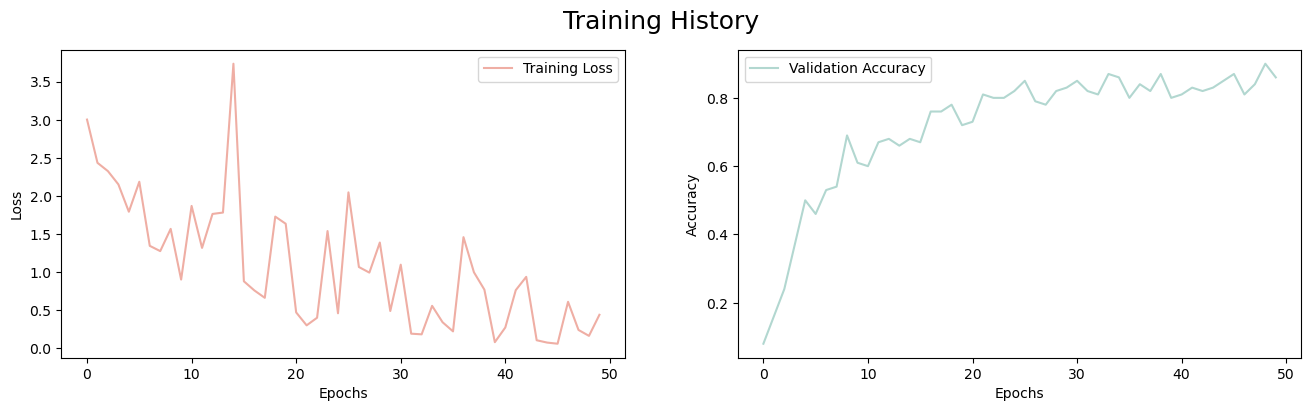

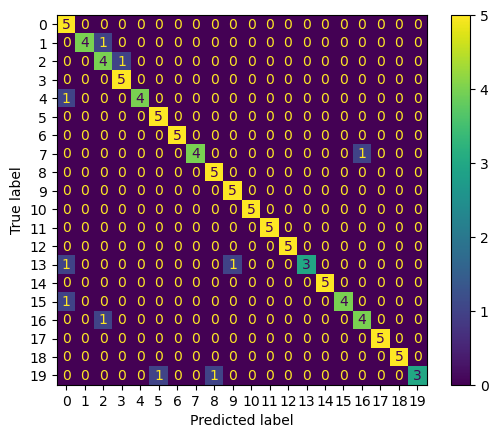

In [17]:
load_plot_model('efficientnet')

In [18]:
# train_save_model('resnet18', train_dataloader, valid_dataloader, epochs=50, save_best=True, best_strategy='loss')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

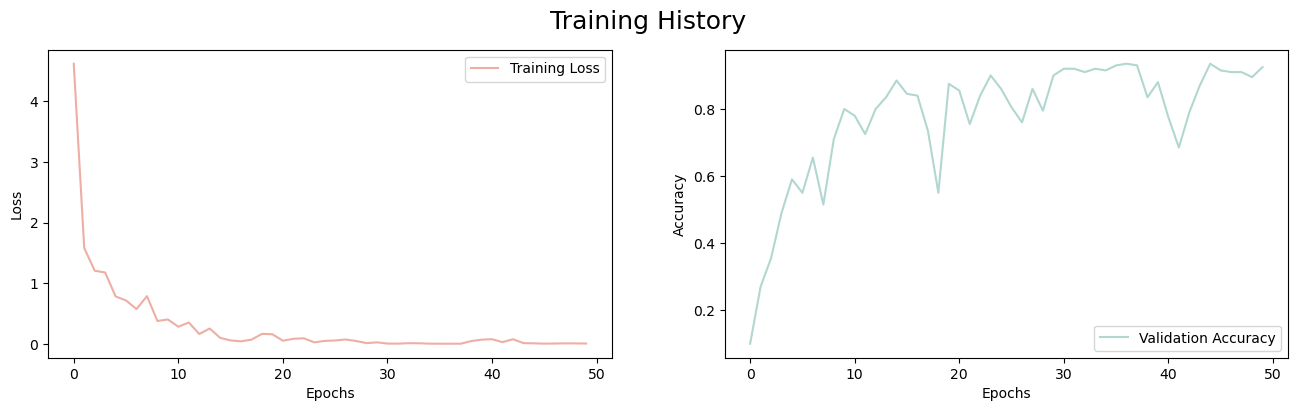

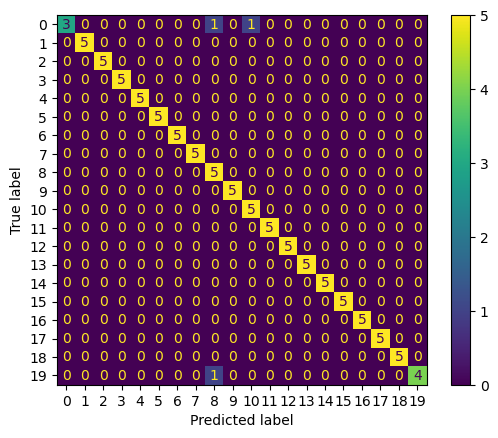

In [19]:
load_plot_model('resnet18')

In [20]:
# train_save_model('inception_res', train_dataloader, valid_dataloader, epochs=50, save_best=True, best_strategy='loss')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           4,736
       BatchNorm2d-2         [-1, 32, 220, 220]              64
         ConvBlock-3         [-1, 32, 220, 220]               0
         MaxPool2d-4         [-1, 32, 110, 110]               0
            Conv2d-5         [-1, 64, 110, 110]          18,496
       BatchNorm2d-6         [-1, 64, 110, 110]             128
         ConvBlock-7         [-1, 64, 110, 110]               0
         MaxPool2d-8           [-1, 64, 55, 55]               0
            Conv2d-9          [-1, 224, 55, 55]          14,560
      BatchNorm2d-10          [-1, 224, 55, 55]             448
        ConvBlock-11          [-1, 224, 55, 55]               0
           Conv2d-12           [-1, 64, 55, 55]           4,160
      BatchNorm2d-13           [-1, 64, 55, 55]             128
        ConvBlock-14           [-1, 64,

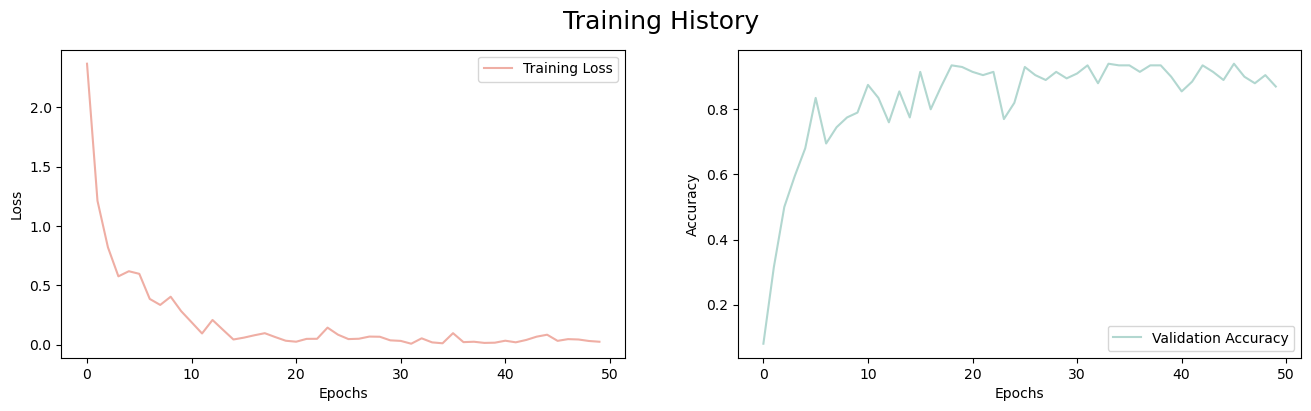

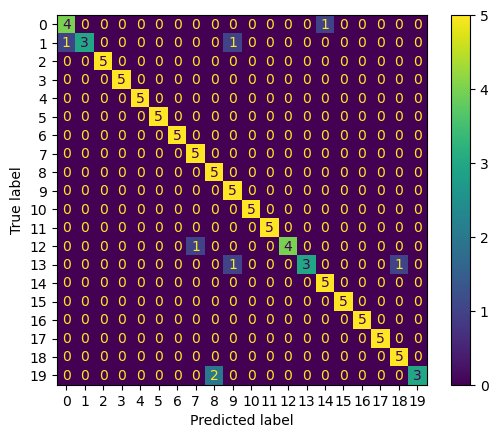

In [21]:
load_plot_model('inception_res')

In [22]:
# train_save_model('cnn_conv4', train_dataloader, valid_dataloader, epochs=50, save_best=True, best_strategy='loss')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 74, 74]           4,736
       BatchNorm2d-2           [-1, 32, 74, 74]              64
         ConvBlock-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 36, 36]          51,264
       BatchNorm2d-5           [-1, 64, 36, 36]             128
         ConvBlock-6           [-1, 64, 36, 36]               0
         MaxPool2d-7           [-1, 64, 18, 18]               0
            Conv2d-8            [-1, 128, 8, 8]         204,928
       BatchNorm2d-9            [-1, 128, 8, 8]             256
        ConvBlock-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
      BatchNorm2d-12            [-1, 256, 8, 8]             512
        ConvBlock-13            [-1, 256, 8, 8]               0
        AvgPool2d-14            [-1, 25

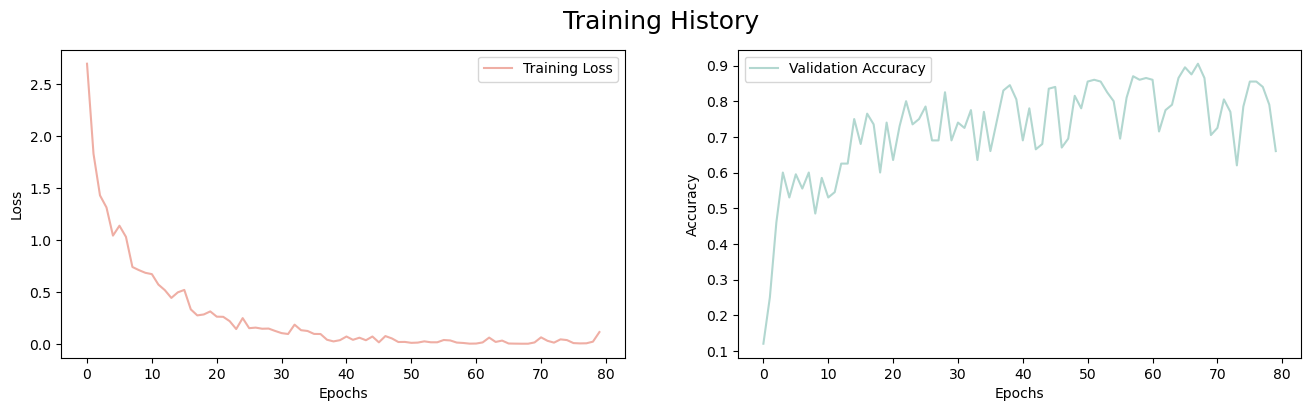

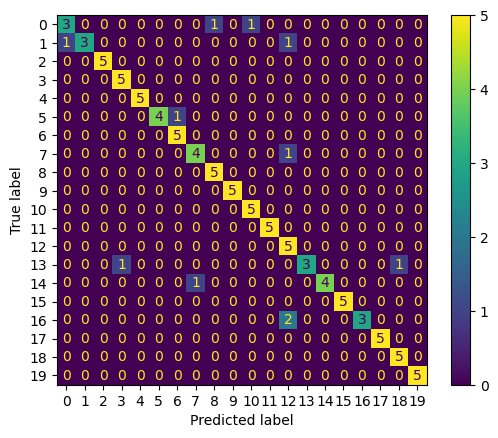

In [23]:
load_plot_model('cnn_conv4')

In [24]:
# train_save_model('cnn_conv8', train_dataloader, valid_dataloader, epochs=50, save_best=True, best_strategy='loss')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 74, 74]           4,736
       BatchNorm2d-2           [-1, 32, 74, 74]              64
         ConvBlock-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 36, 36]          51,264
       BatchNorm2d-5           [-1, 64, 36, 36]             128
         ConvBlock-6           [-1, 64, 36, 36]               0
         MaxPool2d-7           [-1, 64, 18, 18]               0
            Conv2d-8          [-1, 128, 16, 16]         204,928
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        ConvBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
      BatchNorm2d-12          [-1, 256, 16, 16]             512
        ConvBlock-13          [-1, 256, 16, 16]               0
        MaxPool2d-14            [-1, 25

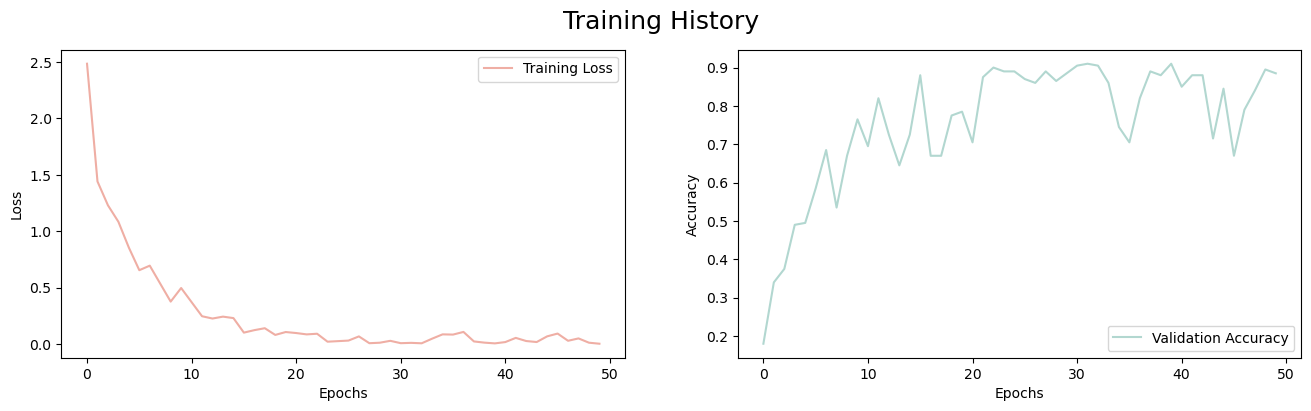

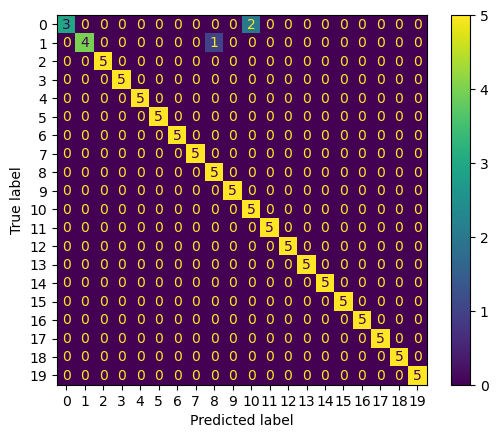

In [25]:
load_plot_model('cnn_conv8')